This script demonstrates why initialization sensitivity is something we are concerned about. We examine a bimodal beta and demonstrate that choice of intial values factors into which mode the VI algorithm finds.

In [1]:
import json
import os
import numpy as np
import jax
import jax.numpy as jnp
from jax.scipy.special import betaln
import numpyro
import numpyro.distributions as dist
from numpyro.infer import SVI, Trace_ELBO, TraceMeanField_ELBO
from numpyro.infer.autoguide import AutoNormal # computes MAP to make family
from numpyro.optim import Adam, Adagrad
import matplotlib.pyplot as plt
from tqdm import tqdm
from bakeoff.posteriors import beta_posterior
from bakeoff.NumPyro.numpyro_svi import run_svi

In [ ]:
# ---- Target: *bimodal* Beta mixture on (0,1)
# Right-heavy and left-heavy components; tweak weights to break symmetry.
alpha_vec = jnp.array([8.0, 2.0])   # component alphas: [8, 2]
beta_vec  = jnp.array([2.0, 8.0])   # component betas:  [2, 8]
mix_probs = jnp.array([0.6, 0.4])   # [0.5, 0.5] => symmetric two equal modes

n_samples = 0
y_data = jnp.array([])
n_parallel = 10

# Seed the guide toward one lobe; flip sign to aim at the other.
init_params = {
    "theta_auto_loc": +2.0,   # try -2.0 to see the other mode
    "theta_auto_scale": 0.7
}
init_pairs = [
    (2.0, 0.7),
    (-2.0, 0.7),
    (0.0, 0.5),
    (1.0, 1.0),
    (-1.0, 1.0),
    (0.5, 0.5)
]

def model(y=None):
    components = dist.Beta(alpha_vec, beta_vec)         # vectorized over 2 comps
    mix = dist.MixtureSameFamily(
        mixing_distribution=dist.Categorical(probs=mix_probs),
        component_distribution=components
    )
    theta = numpyro.sample("theta", mix)
    if y is not None:
        numpyro.sample("obs", dist.Binomial(n_samples, theta), obs=y)

optimizer = Adam(step_size=1e-2)
elbo = TraceMeanField_ELBO(num_particles=100)
guide = AutoNormal(model)
def_guide = AutoNormal(model)
posteriors = []
for i in range(len(init_pairs)):
    temp_guide = AutoNormal(model)
    temp_svi = SVI(model, temp_guide, optimizer, elbo)
    print(init_pairs[i])
    temp_elbos, temp_numpyro_elbos, temp_trackers = run_svi(
        'theta', temp_svi, y_data,
        model_str='beta',
        guide_str='sigmoidnormal',
        model_vals=(alpha_vec[0], beta_vec[0]),
        grad_samps=100, n_parallel=n_parallel,
        max_iters=1_000_000, RANDOM_SEED=10 + i,
        with_data=False, init_params={
            "theta_auto_loc": init_pairs[i][0],
            "theta_auto_scale": init_pairs[i][1]
        }
    )
    final_loc = temp_trackers['mu_loc'][-1][-1]
    final_scale = temp_trackers['std_loc'][-1][-1]
    posteriors.append((final_loc, final_scale))

# init_svi = SVI(model, guide, optimizer, elbo)
default_svi = SVI(model, def_guide, optimizer, elbo)

# init_elbos, init_numpyro_elbos, init_trackers = run_svi(
#     'theta', init_svi, y_data,
#     model_str='beta',
#     guide_str='sigmoidnormal',
#     model_vals=(alpha_vec[0], beta_vec[0]),
#     grad_samps=100, n_parallel=n_parallel,
#     max_iters=1_000_000, RANDOM_SEED=20,
#     with_data=False, init_params=init_params
# )


def_elbos, def_numpyro_elbos, def_trackers = run_svi(
    'theta', default_svi, y_data,
    model_str='beta',
    guide_str='sigmoidnormal',
    model_vals=(alpha_vec[0], beta_vec[0]),
    grad_samps=100, n_parallel=n_parallel,
    max_iters=1_000_000, RANDOM_SEED=60,
    with_data=False
)


(2.0, 0.7)
Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=3/0)>
Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=3/0)>
(-2.0, 0.7)
Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=3/0)>
Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=3/0)>
(0.0, 0.5)
Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=3/0)>
Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=3/0)>
(1.0, 1.0)
Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=3/0)>
Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=3/0)>
(-1.0, 1.0)
Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=3/0)>
Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=3/0)>
(0.5, 0.5)
Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=3/0)>
Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=3/0)>
Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=3/0)>
Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=3/0)>


NameError: name 'init_trackers' is not defined

In [7]:
# correct the posteriors
new_posteriors = []
for i in range(len(posteriors)):
    loc, scale = posteriors[i][0][-1], posteriors[i][1][-1]
    new_posteriors.append((loc, scale))
posteriors = new_posteriors

In [8]:
def_mus = def_trackers['mu_loc']
def_sigmas = def_trackers['std_loc']
def beta_mixture_pdf(x, alpha_vec, beta_vec, mix_probs):
    x = jnp.clip(x, 1e-6, 1 - 1e-6)
    comps = dist.Beta(alpha_vec, beta_vec)           # vectorized over K components
    log_pdf = comps.log_prob(x[:, None])             # [n_x, K]
    pdf = jnp.exp(log_pdf)                           # [n_x, K]
    return (pdf * mix_probs).sum(axis=1)             # [n_x]

def sigmoidnormal_pdf(x, mu, sigma):
    # y ~ Normal(mu, sigma), x = sigmoid(y)
    x = jnp.clip(x, 1e-6, 1 - 1e-6)
    y = jnp.log(x) - jnp.log1p(-x)                   # logit(x)
    norm = dist.Normal(mu, sigma)
    return jnp.exp(norm.log_prob(y)) / (x * (1 - x))

# ---- grid
xs = jnp.linspace(1e-4, 1 - 1e-4, 1000)

# ---- target: mixture-of-Betas (assumes you already defined alpha_vec, beta_vec, mix_probs)
target_pdf = beta_mixture_pdf(xs, alpha_vec, beta_vec, mix_probs)


def_mus_np     = np.asarray(def_mus).reshape(-1)
def_sigmas_np  = np.asarray(def_sigmas).reshape(-1)

mu_b, sig_b = float(def_mus_np[0]),  float(def_sigmas_np[0])

init_pdfs = []
for i in range(len(posteriors)):
    mu_a, sig_a = posteriors[i]
    init_pdfs.append(sigmoidnormal_pdf(xs, mu_a, sig_a))
    print(f"Init {i}: mu = {mu_a:.3f}, sigma = {sig_a:.3f}")
# guide_a_pdf = sigmoidnormal_pdf(xs, mu_a, sig_a)
def_guide_pdf = sigmoidnormal_pdf(xs, mu_b, sig_b)


Init 0: mu = 0.309, sigma = 1.788
Init 1: mu = 0.272, sigma = 1.776
Init 2: mu = 0.349, sigma = 1.813
Init 3: mu = 0.309, sigma = 1.864
Init 4: mu = 0.281, sigma = 1.800
Init 5: mu = 0.261, sigma = 1.794


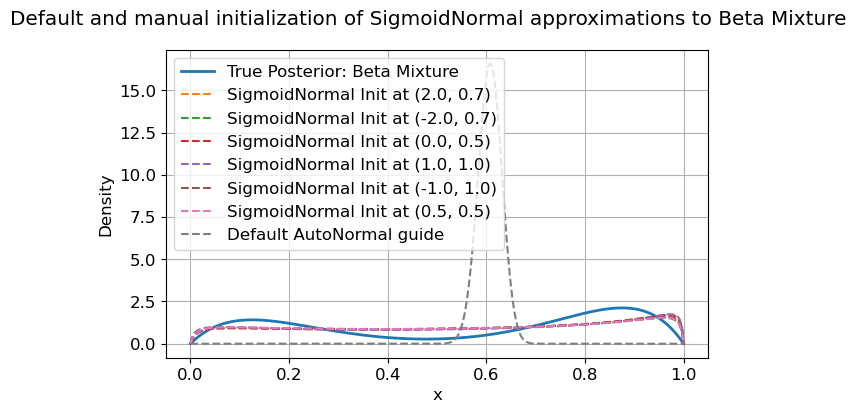

In [9]:

# ---- plot
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(7,4))
plt.plot(np.array(xs), np.array(target_pdf), label='True Posterior: Beta Mixture', linewidth=2)
for i in range(len(init_pdfs)):
    plt.plot(np.array(xs), np.array(init_pdfs[i]), '--', label=f'SigmoidNormal Init at {init_pairs[i]}')
# plt.plot(np.array(xs), np.array(guide_a_pdf), '--', label='SigmoidNormal Initialized at (2, 0.7)')
plt.plot(np.array(xs), np.array(def_guide_pdf), '--', label='Default AutoNormal guide')

plt.xlabel('x')
plt.ylabel('Density')
plt.legend(bbox_to_anchor=(0.0, 1.0), loc='upper left')
plt.grid()
plt.suptitle('Default and manual initialization of SigmoidNormal approximations to Beta Mixture')
plt.show()

